Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Антон Осипов"
COLLABORATORS = ""

---

In [2]:
import numpy as np
from scipy.linalg import block_diag

Рассмотрим систему линейных уравнений, матрица правой части которой является "ленточной" и имеет следующую структуру: ненулевые элементы расположены на трех центральных диагонялях и на двух "крыльях". Матрицы такой структуры возникают, например, при решении задачи на нахождение электростатического потенциала $\phi(x, y)$, cоздаваемого двумерным распределением заряда $\rho(x, y)$ при дискретизации на сетке уравнения Пуассона

$$
\Delta \phi = -4\pi \rho\;.
$$

(детали см. напр. А.А. Самарский, А.В. Гулин, Численные методы, ч. 3 гл. 1, параграф 1).

Размер матрицы растет с уменьшением шага сетки $h$ как $O(1/h^2)$. Таким образом, приходится иметь дело с разреженными матрицами огромного размера.

Матрицу `m` создадим следующим образом:

In [3]:
def lhs_matrix(n):
    # Диагональный блок
    a = np.zeros((n-1, n-1))

    idx = np.arange(n-1)

    a[idx, idx] = -4
    a[idx[:-1], idx[:-1]+1] = 1
    a[idx[1:], idx[1:]-1] = 1

    # собираем блочно-диагональную матрицу `m`
    m = block_diag(*(a,)*n)

    # заполняем "крылья"
    idx = np.arange(m.shape[0])

    m[idx[:-n+1], idx[:-n+1] + n-1] = 1
    m[idx[n-1:], idx[n-1:] - n+1] = 1
    return m

In [4]:
m = lhs_matrix(5)

with np.printoptions(linewidth=99):
    print(m)

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0

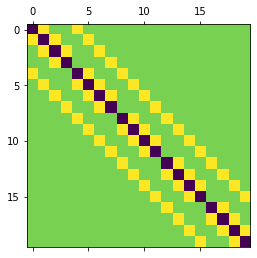

In [5]:
import matplotlib.pyplot as plt
plt.matshow(m)

Зададим вектор правой части системы $b$, символизирующий точечный заряд в центре:

In [6]:
b = np.zeros(m.shape[0])
b[m.shape[0]//2] = -1

Составьте функцию, вычисляющую решение системы уравнений $m x = b$ **методом Зейделя** с заданной точностью $\epsilon$.

Не пользуйтесь функциями `np.linalg.solve`, `np.linalg.inv` и т.п. Обратите внимание на функции `np.triu` и `scipy.linalg.solve_triangular`.

In [7]:
from scipy.linalg import solve_triangular

def seidel_solve(m, b, x0, eps=1e-5, maxiter=500):
    """ Solve `m @ x = b` with Seidel iteration.
    
    Parameters
    ----------
    m : ndarray, shape (n, n)
       Input matrix
    b : ndarray, shape (n,)
       Right-hand side
    x0 : ndarray, shape (n, )
       Initial point for the iteration
    eps : float, optional
       Target accuracy.
       Stop iterations when the 2-norm of 
       `|x_k - x_{k-1}| < eps`
    maxiter : int
       Maximum allowed number of iterations.
       
    Returns
    -------
    x : ndarray, shape (n,)
       The approximation to the solution of `m @ x = b`
    nit : the number of iterations performed.
    """
    nit = 0
    x = np.copy(x0)
    LD = np.tril(m)
    U = m - LD
    while nit < maxiter and np.linalg.norm(m @ x - b) > eps:
      x = solve_triangular(LD,- U @ x + b,lower = True)
      nit+=1
    return x, nit
    

In [8]:
m = lhs_matrix(n=6)
b = np.zeros(m.shape[0])
b[b.size//2] = 1

x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0)

from numpy.testing import assert_allclose
assert_allclose(x,
                np.linalg.solve(m, b), atol=2e-5)

### BEGIN HIDDEN TESTS
m = lhs_matrix(n=15)
b = np.zeros(m.shape[0])
b[b.size//2] = 1

ground_truth = np.linalg.solve(m, b)


# try stubbing out solve/inv
try:
    np.linalg.solve = None
    np.linalg.inv = None
except:
    pass

x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0, eps=1e-6, maxiter=1000)

assert_allclose(x, ground_truth, atol=5e-6)
### END HIDDEN TESTS

Прокомментируйте зависимость числа итераций, требуемых для достижения заданной точности, от $\epsilon$. (без оценки)

In [9]:
print(x)

[-0.00413231 -0.00826075 -0.01234755 -0.01628714 -0.01987721 -0.02280934
 -0.02470519 -0.02522214 -0.02420914 -0.02180262 -0.01833143 -0.0141622
 -0.00959589 -0.00483522 -0.00826852 -0.01656318 -0.02484233 -0.03292385
 -0.04041241 -0.046655   -0.05078934 -0.05197425 -0.04981183 -0.04466993
 -0.03736092 -0.02872152 -0.01938613 -0.00974501 -0.0123786  -0.02488114
 -0.0375348  -0.05015356 -0.06219365 -0.07260897 -0.07982298 -0.08207376
 -0.07839407 -0.0697044  -0.05772085 -0.04397684 -0.02948213 -0.01475868
 -0.01636476 -0.03304803 -0.05026222 -0.06796201 -0.08559976 -0.10176432
 -0.11381994 -0.11810383 -0.11198637 -0.09803283 -0.07984127 -0.05998292
 -0.03980688 -0.01980761 -0.02003244 -0.04068407 -0.06250412 -0.0858326
 -0.11047913 -0.13502874 -0.15558872 -0.16453534 -0.15341485 -0.13059936
 -0.10362855 -0.07630674 -0.0499549  -0.02466489 -0.02308098 -0.04715174
 -0.07323768 -0.10238525 -0.13545555 -0.17228292 -0.20897097 -0.23103406
 -0.20653845 -0.16732128 -0.12776692 -0.09166063 -0.0

In [10]:
## Your code here.

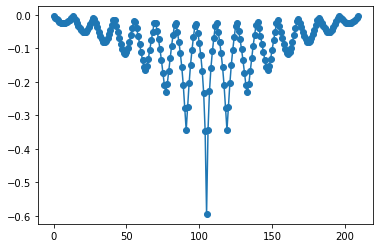

In [11]:
# Постройте график решения как функцию индекса компоненты вектора. 
# Прокомментируйте характер зависимости (без оценки).
plt.plot(x, 'o-')